In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy

---
# VIDEO: Mean-smooth a time series
---

In [ ]:
srate = 1000
time = np.arange(0,3,1/srate) # 3 seconds
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(np.linspace(0,p,n), np.arange(0,p), np.random.rand(p)*30) # interpolate y = interp(x, xp, fp) where x is the coordinates for interpolation, xp are the poles, fp are the y-coordinates of the xp poles. Will return y which is the same length as x
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

print(np.linspace(0,p,n))
print(np.arange(0,p))
print(np.random.rand(p))

# Plotting for debugging
plt.plot(time, ampl)
plt.show()
plt.plot(time, noise)
plt.show()
plt.plot(time, signal)
plt.show()

# initialize filtered signal vector
filtsig = np.zeros(n)

# implement the running mean filter
k = 50 # filter window is actually k*2+1 
print(f"range of filtsig = {range(k, n-k-1)}")
for i in range(k,n-k-1):
    # each point is the average of k surrounding points
    filtsig[i] = np.mean(signal[i-k:i+k])

# compute window size in ms
windowsize = 1000 * (k*2+1) / srate

# plot the noisy and filtered signals
plt.plot(time, signal, label='orig')
plt.plot(time, filtsig, label='filtered')

plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Running-mean filter with a k=%d=ms' %windowsize)

plt.show()



---
# VIDEO: Gaussian-smooth a time series
---

In [ ]:
# create signal
srate = 1000 # Hz
time = np.arange(0,3,1/srate)
n = len(time)
p = 15 # poles for random interpolation

# noise level, measured in standard deviations
noiseamp = 5

# amplitude modulator and noise level
ampl = np.interp(linspace(1,p,n), np.arange(0,p), np.random.rand(p)*30)
noise = noiseamp * np.random.randn(n)
signal = ampl + noise

## Create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 100 # in ms

# normalized time vector in ms 
k = 100
gtime = 1000*np.arange(-k,k) / srate

# create Gaussian window 
gauswin = np.exp(-(4*np.log(2)*gtime**2) / fwhm**2)

# compute empirical FWHM 
pstPeakHalf = k+np.argmin((gauswin[k:]-0.5)**2) # find the index in gaussian window corresponding to half the maximum value, then square it because there are positive and negative values 
prePeakHalf = np.argmin((gauswin-0.5)**2) # do the same thing but for the first half of the gaussian window before the peak 

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian 
plt.plot(gtime, gauswin, 'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]], [gauswin[prePeakHalf], gauswin[pstPeakHalf]], 'm')

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()


In [ ]:
## implement the filter

# initialize filtered signal vector
filtsigG = copy.deepcopy(signal)

# implement the gaussian window filter
for i in range(k+1, n-k-1):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(signal[i-k:i+k] * gauswin)

# plot
plt.plot(time, signal,  'r', label='Original')
plt.plot(time, filtsigG, 'k', label='Gaussian-filtered')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.')
plt.legend()
plt.title('Gaussian smoothing filter')

## for comparison, plot mean smoothing filter

# initialize filtered signal vector 
filtsigMean = copy.deepcopy(signal)

# implement the running mean filter
# note: using mk instead of k to avoid confusion with k above
mk = 20 # filter window is actually mk*2+1
for i in range(mk+1, n-mk-1):
    # each point is the average of k surrounding points
    filtsigMean[i] = mean(signal[i-mk:i+mk])
plt.plot(time, filtsigMean, 'b', label='Running mean')
plt.legend()
plt.show()

---
# VIDEO: Gaussian-smooth a spike time series
---

In [ ]:
## generate time series of random spikes

# number of spikes
n = 300 

# inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp(np.random.randn(n))*10) # this generates an exponential distribution where there is are a lot of short interspike intervals but less longer interspike intervals 
plt.hist(isi)
plt.show()

# generate spike time series
spikets = np.zeros(int(sum(isi))) # add up all the interspike intervals to get the total length of the time vector

for i in range(0, n):
    spikets[int(np.sum(isi[0:i]))] = 1 # loop through each interspike interval value and set to 1. Add them up one by one as you go through the loop to get the right spike times

# plot
plt.plot(spikets)
plt.xlabel('Time (a.u.)')
plt.show()

In [ ]:
## create and implement Gaussian window

# full-width half-maximum: the key Gaussian parameter
fwhm = 50 # in points

# normalized time vector in ms
k = 100
gtime = np.arange(-k,k)

# create Gaussian window
gauswin = np.exp(-(4*log(2)*gtime**2) / fwhm**2)
gauswin = gauswin / np.sum(gauswin)

# initialize filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement filtered signal vector
filtsigG = np.zeros(len(spikets))

# implement the weighted running mean filter
for i in range(k+1, len(spikets)-k-1):
    filtsigG[i] = np.sum(spikets[i-k:i+k] * gauswin)

# plot the filtered signal (spike probability density)
plt.plot(spikets, 'b', label='spikes')
plt.plot(filtsigG, 'r', label='spike p.d.')
plt.legend()
plt.title('Spikes and spike probability density')
plt.show()

---
# VIDEO: Denoising via TKEO
---

In [ ]:
# import data
emgdata = sio.loadmat('emg4TKEO.mat')

# extract needed variables
emgtime = emgdata['emgtime'][0]
emg = emgdata['emg'][0]

# initialize filtered signal
emgf = copy.deepcopy(emg)

# the loop version for interpretability
for i in range(1, len(emgf)-1):
    emgf[i] = emg[i]**2 - emg[i-1]*emg[i+1]


# the vectorized version for speed and elegance
emgf2 = copy.deepcopy(emg)
emgf2[1:-1] = emg[i:-1]**2 - emg[0:-2]*emg[2:] # three vectors, main vector gets squared from 1 to end-1 and you subtract the product of the vector that starts at 0 and ends at end-2 multiplied by the time point ahead which starts at 2 and ends with the last time point

## convert both signal to zscore

# find timepoint zero
time0 = np.argmin(emgtime**2)

# convert original EMG to z-score from time-zero
emgZ = (emg-np.mean(emg[0:time0])) / np.std(emg[0:time0])

# same for filtered EMG energy
emgZf = (emgf - np.mean(emgf[0:time0])) / std(emgf[0:time0])

## plot
# plot "raw" (normalized to max. 1)
plt.plot(emgtime, emg/np.max(emg), 'b', label='EMG')
plt.plot(emgtime, emgf/np.max(emgf), 'm', label='TKEO energy')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude or energy')
plt.legend()

plt.show()

# plot zscored
plt.plot(emgtime, emgZ, 'b', label='EMG')
plt.plot(emgtime, emgZf, 'm', label='TKEO Energy')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()




---
# VIDEO: Median filter to remove spike noise
---

In [ ]:
# create signal 
n = 2000
signal = np.cumsum(np.random.randn(n))

# proportion of time points to replace with noise
propnoise = 0.05

# find noise points
noisepnts = np.random.permutation(n) # randomly reorder time points
print(noisepnts)
noisepnts = noisepnts[0:int(n*propnoise)] # choose the first 0.05% of noise points
print(noisepnts)


# generate signal and replace points with noise
signal[noisepnts] = 50 + np.random.rand(len(noisepnts))*100 

plt.plot(signal)
plt.show()

# use hist to pick threshold
plt.hist(signal, 100)
plt.show()

# visual-picked threshold
threshold = 40

# find data values above the threshold 
suprathresh = np.where(signal > threshold)[0]

# initialize the filtered signal 
filtsig = copy.deepcopy(signal)

# loop through suprathreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(suprathresh)):

    #lower and upper bounds
    lowbnd = np.max((0, suprathresh[ti] - k))
    uppbnd = np.min((suprathresh[ti]+k, n+1))

    # compute median of surrounding points
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])

# plot
plt.plot(range(0, n), signal, range(0, n), filtsig)
plt.show()

---
# VIDEO: Remove linear trend
---

In [ ]:
# create signal with linear trend imposed
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30, 30, n)

# linear detrending
detsignal = scipy.signal.detrend(signal)

# get means
omean = np.mean(signal) # original mean
dmean = np.mean(detsignal) # detrended mean

# plot signal and detrended signal 
plt.plot(range(0, n), signal, label='Original, mean=%d' %omean)
plt.plot(range(0, n), detsignal, label='Detrended, mean=%d' %dmean)

plt.legend()
plt.show()

--- 
# VIDEO: Remove nonlinear trend with polynomials
---

In [ ]:
## polynomial intuition

order = 2 
x = np.linspace(-15, 15, 100)

y = np.zeros(len(x))

for i in range(order+1):
    y = y + np.random.randn(1)*x**i

plt.plot(x, y)
plt.title('Order-%d polynomial' %order)
plt.show()

In [ ]:
## generate siganl with slow polynomial artifact

n = 1000
t = range(n)
k = 10 # number of poles for random amplitudes

slowdrift = np.interp(np.linspace(1, k, n), np.arange(0, k), 100*np.random.randn(k))
signal = slowdrift + 20*np.random.randn(n)

# plot
plt.plot(t, signal)
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
## fit a 3-order polynomial

# polynomial fit (returns coefficients)
p = polyfit(t, signal, 3)

# predicted data is evaluation of polynomial
yHat = polyval(p, t)

# compute residual (the cleaned signal)
residual = signal - yHat

# now polt the fit (the function that will be removed)

plt.plot(t, signal, 'b', label='Original')
plt.plot(t, yHat, 'r', label='Polyfit')
plt.plot(t, residual, 'k', label='Filtered signal')

plt.legend()
plt.show()

In [ ]:
## Bayes information criterion to find optimal order
# possible orders
orders = range(5, 40)

# sum of squared errors (sse is reserved!)
sse1 = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):

    # compute polynomial ( fitting time series)
    yHat = np.polyval(polyfit(t, signal, orders[ri]), t)

    # compute fit of model to data (sum of squared errors)
    sse1[ri] = np.sum((yHat-signal)**2)/n

# Bayes information criterion 
bic = n*np.log(sse1) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
plt.plot(orders, bic, 'ks-')
plt.plot(orders[idx], bestP, 'ro')
plt.xlabel('Polynomial order')
plt.ylabel('Bayes information criterion')
plt.show()

In [ ]:
## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = polyfit(t, signal, orders[idx])

# estimated data based on the coefficients 
yHat = polyval(polycoefs, t)

# filtered signal is residual
filtsig = signal - yHat

## plotting
plt.plot(t, signal, 'b', label='Original')
plt.plot(t, yHat, 'r', label='Polynommial fit')
plt.plot(t, filtsig, 'k', label='Filtered')

plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

---
# VIDEO: Averaging multiple repetitions (time-synchronous averaging)
---

In [ ]:
## simulate data

# create event (derivative of Gaussian)
k = 100 # duration of event in time points
event = np.diff(np.exp(-np.linspace(-2,2,k+1)**2))
event = event/np.max(event) # normalize to max = 1

# event onset times
Nevents = 30 
onsettimes = np.random.permutation(10000 - k)
onsettimes = onsettimes[0:Nevents]

# put event into data
data = np.zeros(10000)
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei]+k] = event

# add noise
data = data + 0.5*np.random.randn(len(data))

# plot data
plt.subplot(211)
plt.plot(data)

# plot one event 
plt.subplot(212)
plt.plot(range(k), data[onsettimes[3]:onsettimes[3]+k])
plt.plot(range(k), event)
plt.show()

In [ ]:
## extract all events into a matrix

datamatrix = np.zeros((Nevents, k))

for ei in range(0, Nevents):
    datamatrix[ei, :] = data[onsettimes[ei]:onsettimes[ei]+k] # need to know what the onset times are, otherwise need template matching or pattern matching

plt.imshow(datamatrix)
plt.xlabel('Time')
plt.ylabel('Event number')
plt.title('All events')
plt.show()

plt.plot(range(0, k), np.mean(datamatrix, axis=0), label='Averaged')
plt.plot(range(0, k), event, label='Ground-truth')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Average events')
plt.show()

---
# VIDEO: Remove artifact via least-squares template-matching
---

In [ ]:
# load dataset
matdat = sio.loadmat('templateProjection.mat')
EEGdat = matdat['EEGdat']
eyedat = matdat['eyedat']
timevec = matdat['timevec'][0]
MN = np.shape(EEGdat) # matrix sizes

# initalize residual data
resdat = zeros(np.shape(EEGdat))

# loop over trials
for triali in range(0, MN[1]):

    # build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]), eyedat[:, triali]))

    # compute regression coefficients for EEG channel
    b = np.linalg.solve(np.matrix.transpose(X)@X, np.matrix.transpose(X)@EEGdat[:, triali])

    # predicted data
    yHat = X@b

    # new data are the residuals after projection out the best EKG fit
    resdat[:, triali] = EEGdat[:, triali] - yHat

In [ ]:
### plotting

# trial averages
plt.plot(timevec,np.mean(eyedat,axis=1),label='EOG')
plt.plot(timevec,np.mean(EEGdat,axis=1),label='EEG')
plt.plot(timevec,np.mean(resdat,1),label='Residual')

plt.xlabel('Time (ms)')
plt.legend()
plt.show()

In [ ]:
# show all trials in a map
clim = [-1, 1]*20
plt.subplot(131)
plt.imshow(eyedat.T)
plt.title('EOG')

plt.subplot(132)
plt.imshow(EEGdat.T)
plt.title('EOG')

plt.subplot(133)
plt.imshow(resdat.T)
plt.title('Residual')
plt.show()

---
# Denoising Code Challenge
---

In [ ]:
# Load code challenge dataset 
challengedat = sio.loadmat('denoising_codeChallenge.mat')
origSignal = challengedat['origSignal'][0] # need to include [0] for loading the array properly
cleanedSignal = challengedat['cleanedSignal'][0]
timevec = range(0,np.shape(origSignal)[0])

# Plot original signal and cleaned signal
plt.subplot(211)
plt.plot(timevec, origSignal)

plt.subplot(212)
plt.plot(timevec, cleanedSignal)

#plt.plot(timevec, origSignal)

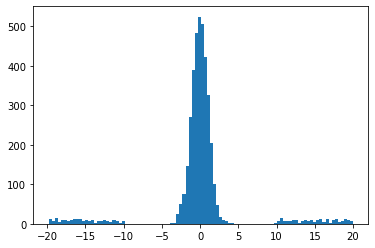

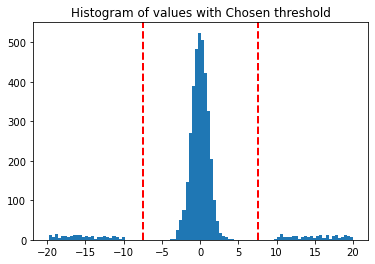

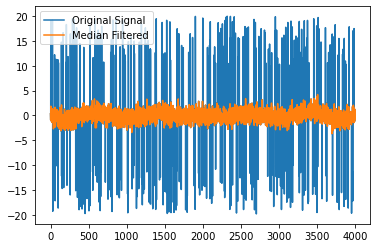

In [42]:
# Develop plan for removing noise
# Probably want to remove the spikes with median filtering
# Also likely want to pull out the slower oscillations. Might be good to look at FFT and filter out high frequency noise, then see where to go from there. 

# Using histogram to plot threshold
plt.hist(origSignal, 100)
plt.show()

# Visual-picked threshold
threshold = 7.5

# find data values above and below threshold 
remove = np.where(abs(origSignal) > threshold)[0]

remove

plt.hist(origSignal, 100)
#plt.plot([threshold, threshold], [0, 600])
plt.axvline(x=-threshold, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=threshold, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of values with Chosen threshold')
plt.show()

# initialize filtered signal
filtSignal = copy.deepcopy(origSignal)

k = 10
for ti in range(len(remove)):

    # lower and upper bounds
    lowbnd = np.max((0, remove[ti]-k))
    uppbnd = np.min((remove[ti]+k, max(timevec)+1))
    # computer median of surrounding points
    filtSignal[remove[ti]] = np.median(filtSignal[lowbnd:uppbnd])

# plot
plt.plot(timevec, origSignal, label='Original Signal')
plt.plot(timevec, filtSignal, label='Median Filtered')
plt.legend()
plt.show()



[-300 -299 -298 -297 -296 -295 -294 -293 -292 -291 -290 -289 -288 -287
 -286 -285 -284 -283 -282 -281 -280 -279 -278 -277 -276 -275 -274 -273
 -272 -271 -270 -269 -268 -267 -266 -265 -264 -263 -262 -261 -260 -259
 -258 -257 -256 -255 -254 -253 -252 -251 -250 -249 -248 -247 -246 -245
 -244 -243 -242 -241 -240 -239 -238 -237 -236 -235 -234 -233 -232 -231
 -230 -229 -228 -227 -226 -225 -224 -223 -222 -221 -220 -219 -218 -217
 -216 -215 -214 -213 -212 -211 -210 -209 -208 -207 -206 -205 -204 -203
 -202 -201 -200 -199 -198 -197 -196 -195 -194 -193 -192 -191 -190 -189
 -188 -187 -186 -185 -184 -183 -182 -181 -180 -179 -178 -177 -176 -175
 -174 -173 -172 -171 -170 -169 -168 -167 -166 -165 -164 -163 -162 -161
 -160 -159 -158 -157 -156 -155 -154 -153 -152 -151 -150 -149 -148 -147
 -146 -145 -144 -143 -142 -141 -140 -139 -138 -137 -136 -135 -134 -133
 -132 -131 -130 -129 -128 -127 -126 -125 -124 -123 -122 -121 -120 -119
 -118 -117 -116 -115 -114 -113 -112 -111 -110 -109 -108 -107 -106 -105
 -104 

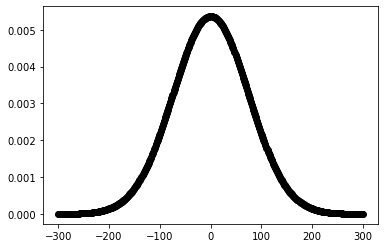

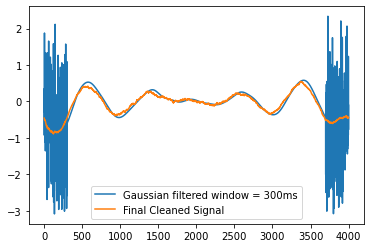

In [86]:
# Mean filter and Gaussian filter after removing spikes with median filter 

# Initialize signal for mean filtering
filtSignal2 = copy.deepcopy(filtSignal)

# Initialize signal for gaussian filtering
filtSignalG = copy.deepcopy(filtSignal)

# create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 175

# create Gaussian window
k = 300
gtime = np.arange(-k,k)
print(gtime)

gauswin = np.exp(-(4*np.log(2)*gtime**2) / fwhm**2)
gauswin = gauswin / np.sum(gauswin)
plt.plot(gtime, gauswin, 'ko-')
plt.show()

n = np.shape(filtSignal2)[0]
for i in range(k+1, n-k-1):
    
    filtSignal2[i] = np.mean(filtSignal[i-k:i+k])
    filtSignalG[i] = np.sum(filtSignal[i-k:i+k]*gauswin)

    

#plt.plot(timevec, origSignal, label='Original Signal')
#plt.plot(timevec, filtSignal, label='Median Filtered')
#plt.plot(timevec, filtSignal2, label='Mean filtered window = %dms' %k)
plt.plot(timevec, filtSignalG, label='Gaussian filtered window = %dms' %k)
plt.plot(timevec, cleanedSignal, label='Final Cleaned Signal')
plt.legend()
plt.show()



In [ ]:
# Try Gaussian filtering

# Try having a dynamic window size in the start of the mean window or gaussian window




